# VAR(Vector AutoRegression)

used for two time series that have effectos on each other... 

In [3]:
import pandas as pd
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

In [6]:
#loading Dataset
df=pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0,parse_dates=True)
df.index.freq='MS'

sp=pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0,parse_dates=True)
sp.index.freq='MS'

In [7]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [8]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [9]:
df=df.join(sp)

In [10]:
df.shape

(252, 2)

In [13]:
df.dropna(inplace=True)
sp.dropna(inplace=True)

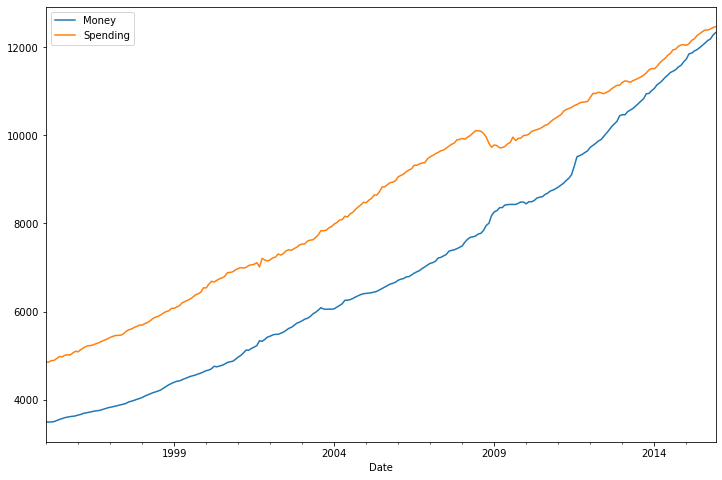

In [17]:
df.plot(figsize=(12,8));

In [18]:
from statsmodels.tsa.stattools import adfuller
def adf_test(time_series):
    """
    The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
    root, with the alternative that there is no unit root. If the pvalue is
    above a critical size, then we cannot reject that there is a unit root.
    """
    test=adfuller(time_series)
    out=pd.Series(test[:4],index=['adf test statistics','p-value','used_lag','n_obs'])
    for k,v in test[4].items():
        out[f"Critical_value_{k}"]=v
    
    if out[1]<0.05:
        print('Stationary data')
    else:
        print('Non-Stationary data')
    return out

In [19]:
adf_test(df['Money'])

Non-Stationary data


adf test statistics      4.239022
p-value                  1.000000
used_lag                 4.000000
n_obs                  247.000000
Critical_value_1%       -3.457105
Critical_value_5%       -2.873314
Critical_value_10%      -2.573044
dtype: float64

In [20]:
adf_test(df['Spending'])

Non-Stationary data


adf test statistics      0.149796
p-value                  0.969301
used_lag                 3.000000
n_obs                  248.000000
Critical_value_1%       -3.456996
Critical_value_5%       -2.873266
Critical_value_10%      -2.573019
dtype: float64

In [53]:
df_transformend=df.diff().dropna() #It was not stationary after 1st differencing
df_transformend=df_transformend.diff().dropna()

In [54]:
adf_test(df_transformend['Money'])

Stationary data


adf test statistics   -7.077471e+00
p-value                4.760675e-10
used_lag               1.400000e+01
n_obs                  2.350000e+02
Critical_value_1%     -3.458487e+00
Critical_value_5%     -2.873919e+00
Critical_value_10%    -2.573367e+00
dtype: float64

In [55]:
adf_test(df_transformend['Spending'])

Stationary data


adf test statistics   -8.760145e+00
p-value                2.687900e-14
used_lag               8.000000e+00
n_obs                  2.410000e+02
Critical_value_1%     -3.457779e+00
Critical_value_5%     -2.873609e+00
Critical_value_10%    -2.573202e+00
dtype: float64

BOth the  dataset became stationary after 2nd order differencing

In [58]:
#num of observations in test set
nobs=12

In [67]:
train=df_transformend[:-nobs]
test=df_transformend[-nobs:]

## Grid Search for Order p AR of VAR model

In [68]:
model=VAR(train)

for p in range(8):
    results=model.fit(p)
    print(f"Order: {p}")
    print(f"AIC: {results.aic}")
    print("\n")

Order: 0
AIC: 14.74710921809045


Order: 1
AIC: 14.178610495220896


Order: 2
AIC: 13.955189367163703


Order: 3
AIC: 13.849518291541038


Order: 4
AIC: 13.827950574458281


Order: 5
AIC: 13.78730034460964


Order: 6
AIC: 13.799076756885809


Order: 7
AIC: 13.79763872791397




#### Lowest AIC at p value 5

In [69]:
results=model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Sep, 2020
Time:                     22:30:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [71]:
#Grab last 5 lag values
lag=train.values[-5:]

In [72]:
z=results.forecast(y=lag,steps=12) #forecasts

In [83]:
#creating a dataframe
idx=pd.date_range('2015-01-01',periods=12,freq='MS')
df_forecast=pd.DataFrame(z,index=idx,columns=['Money_2d','Spending_2d'])

In [78]:
df_forecast

,Money_2d,SPending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


In [84]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [85]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [86]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


# plotting

test data is diffrencend data... can't plot with forecasted data... Hence

In [87]:
test_range=df[-nobs:]

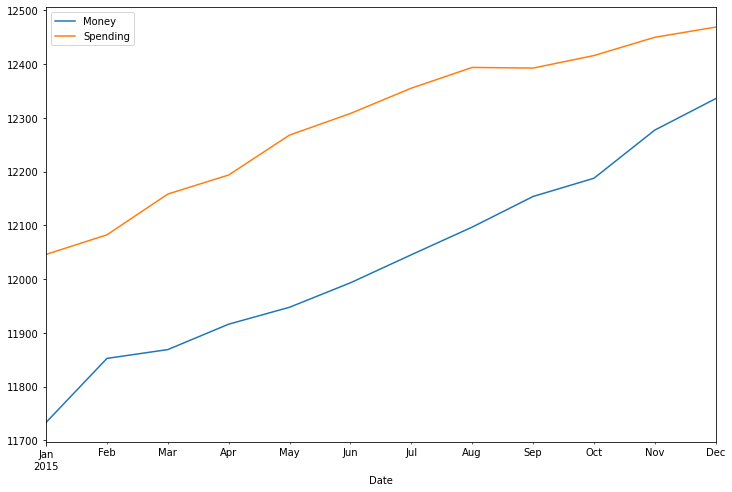

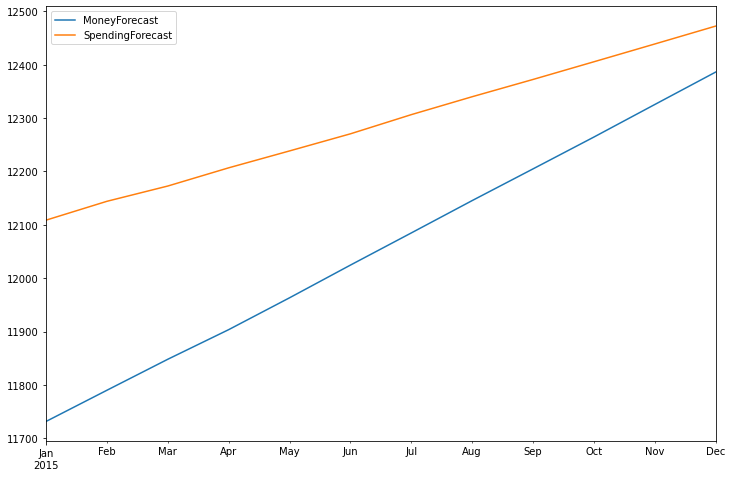

In [91]:
test_range.plot(figsize=(12,8))
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(12,8));

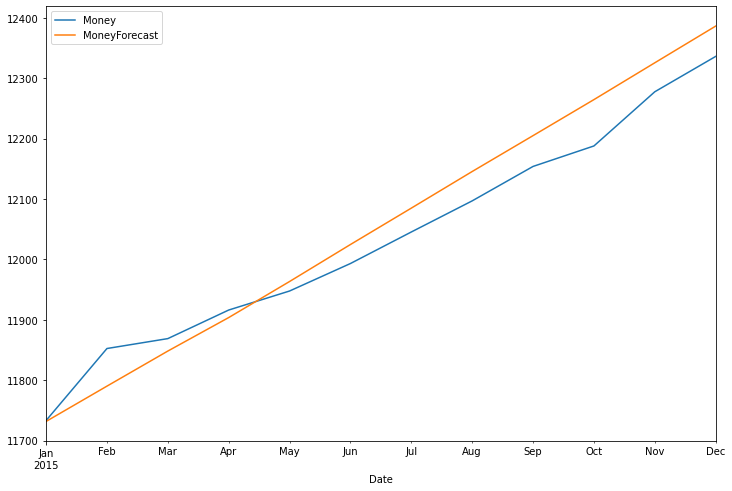

In [92]:
test_range['Money'].plot(legend=True,figsize=(12,8))
df_forecast['MoneyForecast'].plot(legend=True);

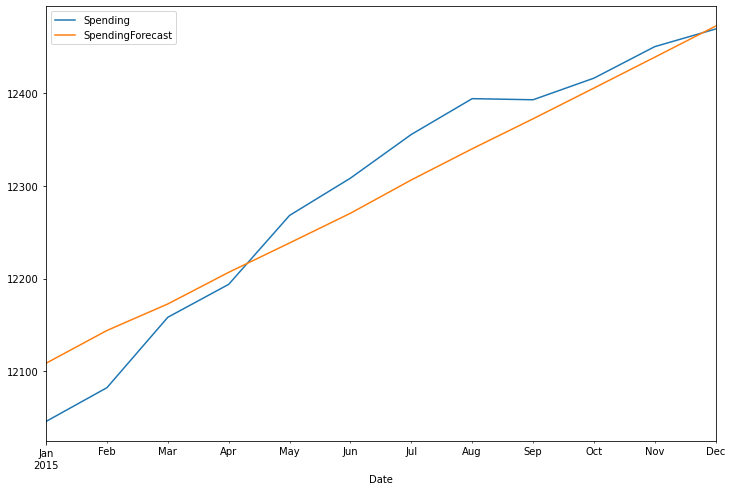

In [93]:
test_range['Spending'].plot(legend=True,figsize=(12,8))
df_forecast['SpendingForecast'].plot(legend=True);

In [94]:
rmse(test_range['Money'],df_forecast['MoneyForecast'])

43.71049653558893

In [95]:
rmse(test_range['Spending'],df_forecast['SpendingForecast'])

37.00117516940808

In [96]:
test_range['Money'].mean(),test_range['Spending'].mean()

(12034.008333333333, 12294.533333333335)

# VARMA (Vector AutoRegressive Moving Average)

After checking the stationarity of data, we run auto_arima to find the best orders

In [109]:
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from pmdarima import auto_arima

In [99]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [101]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [102]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [103]:
len(df_transformed)

250

## Train/test/split

In [107]:
nobs=12
train, test = df_transformed[:-nobs], df_transformed[-nobs:]

In [108]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(1,2) Model

In [110]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.077
,+ intercept,AIC,4606.154
Date:,"Wed, 02 Sep 2020",BIC,4665.183
Time:,01:50:18,HQIC,4629.944
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.02, 29.13",Jarque-Bera (JB):,"527.45, 108.92"
Prob(Q):,"0.00, 0.90",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.44, 2.97",Skew:,"1.30, -0.32"


In [111]:
df_forecast = results.forecast(12)
df_forecast

c:\users\rhitc\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


,Money,Spending
2015-01-01,-10.303328,37.337527
2015-02-01,-10.748984,-3.742657
2015-03-01,0.201679,-0.352868
2015-04-01,-1.392663,-0.301678
2015-05-01,0.523283,0.173934
2015-06-01,-0.118787,0.078715
2015-07-01,0.294738,0.167530
2015-08-01,0.113382,0.134707
2015-09-01,0.211859,0.154536
2015-10-01,0.164586,0.145548


In [112]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [113]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [114]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-10.303328,37.337527,68.296672,11659.796672,47.937527,12099.337527
2015-02-01,-10.748984,-3.742657,57.547689,11649.047689,44.194869,12095.594869
2015-03-01,0.201679,-0.352868,57.749368,11649.249368,43.842001,12095.242001
2015-04-01,-1.392663,-0.301678,56.356705,11647.856705,43.540322,12094.940322
2015-05-01,0.523283,0.173934,56.879988,11648.379988,43.714256,12095.114256
2015-06-01,-0.118787,0.078715,56.761201,11648.261201,43.792972,12095.192972
2015-07-01,0.294738,0.167530,57.055939,11648.555939,43.960502,12095.360502
2015-08-01,0.113382,0.134707,57.169321,11648.669321,44.095209,12095.495209
2015-09-01,0.211859,0.154536,57.381180,11648.881180,44.249746,12095.649746
2015-10-01,0.164586,0.145548,57.545766,11649.045766,44.395294,12095.795294


In [115]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11659.796672,12099.337527
2015-02-01,11852.4,12082.4,11649.047689,12095.594869
2015-03-01,11868.8,12158.3,11649.249368,12095.242001
2015-04-01,11916.1,12193.8,11647.856705,12094.940322
2015-05-01,11947.6,12268.1,11648.379988,12095.114256
2015-06-01,11993.1,12308.3,11648.261201,12095.192972
2015-07-01,12045.3,12355.4,11648.555939,12095.360502
2015-08-01,12096.8,12394.0,11648.669321,12095.495209
2015-09-01,12153.8,12392.8,11648.881180,12095.649746


# Plotting 

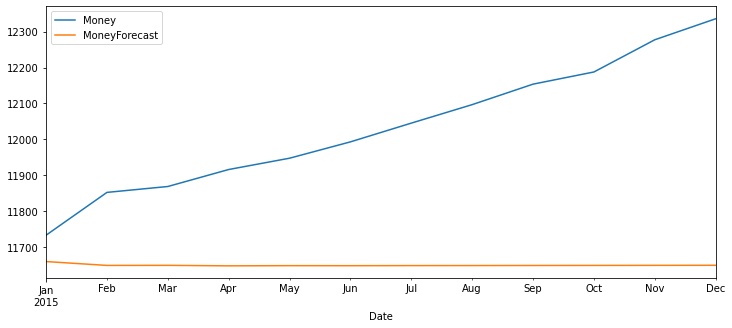

In [116]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

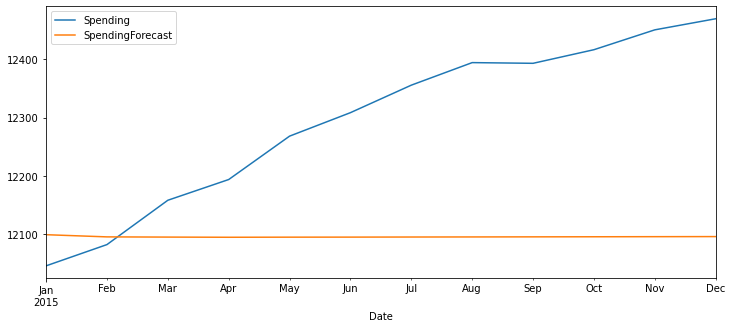

In [117]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [118]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 422.741


In [119]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 242.261


##### This model VARMA did give poor results as compared to simple model VAR and ARMA and AR. AR gave the best result here. It proves there is no dependencies betweent the variable Spending and Money.